In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
from scipy.io import arff
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams
from sklearn.metrics import accuracy_score

# Import the data
# Uncomment exactly one of these lines

# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-15s.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-30s.arff')
arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-120s.arff')

data = pd.DataFrame(arff_data[0])
# The columns are incorrectly labeled. This is our best guess at the correct ordering of the labels
data = data.rename(columns={"total_fiat":"min_fiat", "total_biat":"min_biat", "min_fiat":"max_fiat", "min_biat":"max_biat", "max_fiat":"mean_fiat", "max_biat":"mean_biat", "mean_fiat":"std_fiat","mean_biat":"std_biat"})
print(len(data))
data.head()

10782


,duration,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,std_fiat,std_biat,flowPktsPerSecond,flowBytesPerSecond,min_flowiat,max_flowiat,mean_flowiat,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,117202678.0,17.0,4.0,35188437.0,35149142.0,4.742976e+05,5.578672e+05,2.502257e+06,2.693576e+06,3.916293,1411.640099,4.0,35137650.0,2.559010e+05,1.839548e+06,1363299.0,5.561680e+06,35334176.0,7.589073e+06,1079974.0,4.426667e+06,35137650.0,7.605741e+06,b'CHAT'
1,119579137.0,16.0,4.0,35208950.0,35022877.0,5.108043e+05,5.410036e+05,2.582052e+06,2.634447e+06,3.821737,1731.104649,4.0,35022877.0,2.622349e+05,1.849452e+06,1443143.0,4.972742e+06,35280803.0,7.131588e+06,1065834.0,4.185795e+06,35022877.0,7.108954e+06,b'CHAT'
2,90462788.0,20.0,5.0,24383019.0,24244301.0,9.812504e+05,1.145099e+06,3.866535e+06,4.125707e+06,1.912389,701.404427,5.0,24244301.0,5.259464e+05,2.842532e+06,2757283.0,9.991859e+06,24613894.0,8.779228e+06,1297996.0,9.071855e+06,24244301.0,9.259661e+06,b'CHAT'
3,65341087.0,18.0,5.0,26116331.0,25978548.0,6.873223e+05,7.503962e+05,3.213452e+06,3.322049e+06,2.815992,1238.133672,5.0,25978548.0,3.570551e+05,2.313499e+06,1566070.0,9.245735e+06,26194797.0,9.349672e+06,1197148.0,8.231822e+06,25978548.0,9.321698e+06,b'CHAT'
4,119999180.0,29999272.0,29999277.0,30001029.0,30001305.0,3.000000e+07,3.000000e+07,8.268222e+02,1.154763e+03,0.075001,6.083375,54824.0,29944585.0,1.500000e+07,1.600000e+07,29999272.0,3.000000e+07,30001029.0,8.268222e+02,29944247.0,2.990000e+07,29944585.0,1.499153e+02,b'CHAT'


In [112]:
# One-hot encode the data
one_hot_data = pd.get_dummies(data, columns=['class1'])
one_hot_data.head()

,duration,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,std_fiat,std_biat,flowPktsPerSecond,flowBytesPerSecond,min_flowiat,max_flowiat,mean_flowiat,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1_b'BROWSING',class1_b'CHAT',class1_b'FT',class1_b'MAIL',class1_b'P2P',class1_b'STREAMING',class1_b'VOIP',class1_b'VPN-BROWSING',class1_b'VPN-CHAT',class1_b'VPN-FT',class1_b'VPN-MAIL',class1_b'VPN-P2P',class1_b'VPN-STREAMING',class1_b'VPN-VOIP'
0,117202678.0,17.0,4.0,35188437.0,35149142.0,4.742976e+05,5.578672e+05,2.502257e+06,2.693576e+06,3.916293,1411.640099,4.0,35137650.0,2.559010e+05,1.839548e+06,1363299.0,5.561680e+06,35334176.0,7.589073e+06,1079974.0,4.426667e+06,35137650.0,7.605741e+06,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,119579137.0,16.0,4.0,35208950.0,35022877.0,5.108043e+05,5.410036e+05,2.582052e+06,2.634447e+06,3.821737,1731.104649,4.0,35022877.0,2.622349e+05,1.849452e+06,1443143.0,4.972742e+06,35280803.0,7.131588e+06,1065834.0,4.185795e+06,35022877.0,7.108954e+06,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,90462788.0,20.0,5.0,24383019.0,24244301.0,9.812504e+05,1.145099e+06,3.866535e+06,4.125707e+06,1.912389,701.404427,5.0,24244301.0,5.259464e+05,2.842532e+06,2757283.0,9.991859e+06,24613894.0,8.779228e+06,1297996.0,9.071855e+06,24244301.0,9.259661e+06,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,65341087.0,18.0,5.0,26116331.0,25978548.0,6.873223e+05,7.503962e+05,3.213452e+06,3.322049e+06,2.815992,1238.133672,5.0,25978548.0,3.570551e+05,2.313499e+06,1566070.0,9.245735e+06,26194797.0,9.349672e+06,1197148.0,8.231822e+06,25978548.0,9.321698e+06,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,119999180.0,29999272.0,29999277.0,30001029.0,30001305.0,3.000000e+07,3.000000e+07,8.268222e+02,1.154763e+03,0.075001,6.083375,54824.0,29944585.0,1.500000e+07,1.600000e+07,29999272.0,3.000000e+07,30001029.0,8.268222e+02,29944247.0,2.990000e+07,29944585.0,1.499153e+02,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [113]:
# Separate the data into test and training
train_data = one_hot_data.sample(frac=0.8)
test_data = one_hot_data.drop(train_data.index)

# Separate the labels from the input features
class_columns = ["class1_b'BROWSING'", "class1_b'CHAT'", "class1_b'FT'", "class1_b'MAIL'", "class1_b'P2P'", "class1_b'STREAMING'", "class1_b'VOIP'", "class1_b'VPN-BROWSING'", "class1_b'VPN-CHAT'", "class1_b'VPN-FT'", "class1_b'VPN-MAIL'", "class1_b'VPN-P2P'", "class1_b'VPN-STREAMING'", "class1_b'VPN-VOIP'"]
x_train = train_data.drop(class_columns, axis=1)
y_train = train_data[class_columns]

# Normalize
norm_min = x_train.min()
norm_range = x_train.max() - x_train.min()

x_train = (x_train - norm_min) / norm_range

# Same for test data
x_test = test_data.drop(class_columns, axis=1)
y_test = test_data[class_columns]

# Normalize using the SAME PARAMETERS AS THE TRAINING SET
x_test = (x_test - norm_min) / norm_range

print('Training Data\n', x_train.describe().transpose(), '\n')
print('Test Data\n', x_test.describe().transpose(), '\n')

# Helpful things for testing accuracy later
class_names = ["BROWSING", "CHAT", "FT", "MAIL", "P2P", "STREAMING", "VOIP", "VPN-BROWSING", "VPN-CHAT", "VPN-FT", "VPN-MAIL", "VPN-P2P", "VPN-STREAMING", "VPN-VOIP"]
y_train_probs = tf.identity(y_train).numpy()
y_train_class = np.argmax(y_train_probs, axis=1)
y_test_probs = tf.identity(y_test).numpy()
y_test_class = np.argmax(y_test_probs, axis=1)
rcParams['figure.figsize'] = (9, 9)


Training Data
                      count      mean       std  ...           50%       75%  max
duration            8626.0  0.074575  0.086899  ...  1.734493e-02  0.165135  1.0
min_fiat            8626.0  0.035745  0.113721  ...  4.833345e-07  0.000015  1.0
min_biat            8626.0  0.029531  0.105231  ...  1.250004e-07  0.000001  1.0
max_fiat            8626.0  0.038138  0.067183  ...  1.752490e-03  0.064871  1.0
max_biat            8626.0  0.024787  0.040114  ...  8.098994e-04  0.041719  1.0
mean_fiat           8626.0  0.043000  0.096605  ...  1.047397e-03  0.035637  1.0
mean_biat           8626.0  0.049011  0.113405  ...  5.340493e-04  0.037821  1.0
std_fiat            8626.0  0.020292  0.053122  ...  1.159203e-04  0.012751  1.0
std_biat            8626.0  0.040335  0.087778  ...  2.007367e-04  0.028739  1.0
flowPktsPerSecond   8626.0  0.004753  0.022645  ...  2.118961e-06  0.000052  1.0
flowBytesPerSecond  8626.0  0.001704  0.021280  ...  1.195327e-06  0.000039  1.0
min_flowiat  

In [114]:
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer([len(x_train.keys())], name="Input_Layer"),
  tf.keras.layers.Dense(32, activation='relu', name="dense_01"),
  tf.keras.layers.Dense(48, activation='relu', name="dense_02"),
  tf.keras.layers.Dense(32, activation='relu', name="dense_03"),
  tf.keras.layers.Dense(len(y_train.keys()), activation='softmax', name="Output_Layer")
])

model.compile(Adam(lr=0.002), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_01 (Dense)             (None, 32)                768       
_________________________________________________________________
dense_02 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_03 (Dense)             (None, 32)                1568      
_________________________________________________________________
Output_Layer (Dense)         (None, 14)                462       
Total params: 4,382
Trainable params: 4,382
Non-trainable params: 0
_________________________________________________________________


In [115]:
history = model.fit(x_train, y_train, batch_size=256, epochs=1000, validation_split=0.2, verbose=1)

Epoch 1/1000
27/27 [==============================] - 1s 12ms/step - loss: 2.5876 - accuracy: 0.1935 - val_loss: 2.2873 - val_accuracy: 0.2381
Epoch 2/1000
27/27 [==============================] - 0s 4ms/step - loss: 2.2658 - accuracy: 0.2403 - val_loss: 2.1300 - val_accuracy: 0.2648
Epoch 3/1000
27/27 [==============================] - 0s 4ms/step - loss: 2.1337 - accuracy: 0.2501 - val_loss: 2.0435 - val_accuracy: 0.2613
Epoch 4/1000
27/27 [==============================] - 0s 4ms/step - loss: 2.0817 - accuracy: 0.2553 - val_loss: 1.9824 - val_accuracy: 0.3013
Epoch 5/1000
27/27 [==============================] - 0s 4ms/step - loss: 2.0063 - accuracy: 0.2955 - val_loss: 1.9114 - val_accuracy: 0.3407
Epoch 6/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.9435 - accuracy: 0.3108 - val_loss: 1.8715 - val_accuracy: 0.3244
Epoch 7/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.9113 - accuracy: 0.3248 - val_loss: 1.8459 - val_accuracy: 0.3436
Epoch

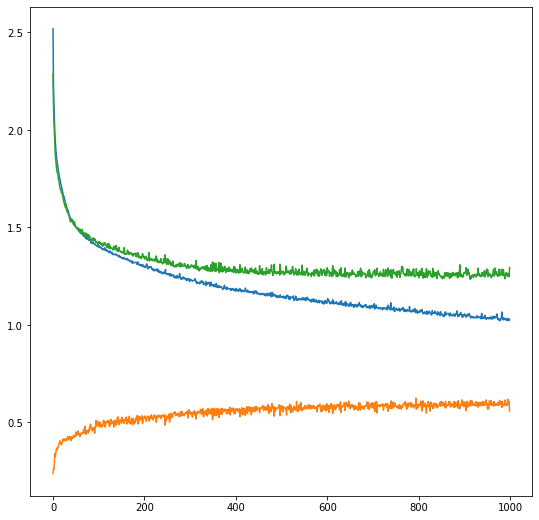

In [116]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
_ = plt.plot(history.history['val_loss'])

0.563543599257885


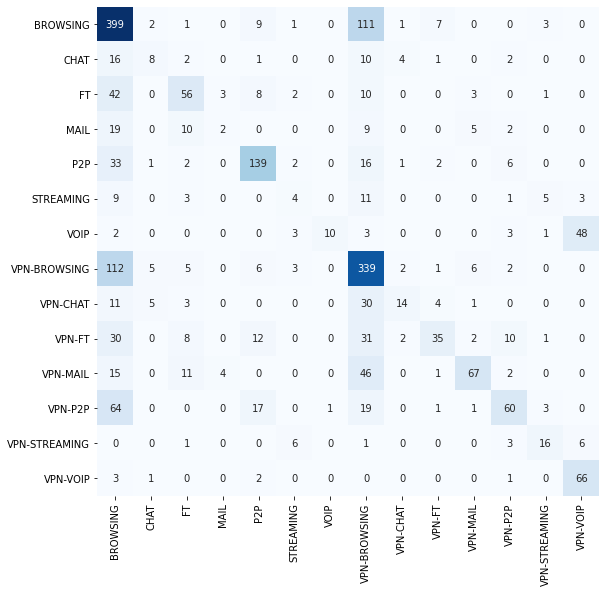

In [117]:
p_test = model.predict(x_test)
p_test_probs = tf.nn.softmax(p_test).numpy()
p_test_class = np.argmax(p_test_probs, axis=1)

print(accuracy_score(p_test_class, y_test_class))
_ = sns.heatmap(tf.math.confusion_matrix(y_test_class, p_test_class), xticklabels=class_names, yticklabels=class_names, cbar=False, cmap='Blues', annot=True, fmt="d")

0.5996985856712265


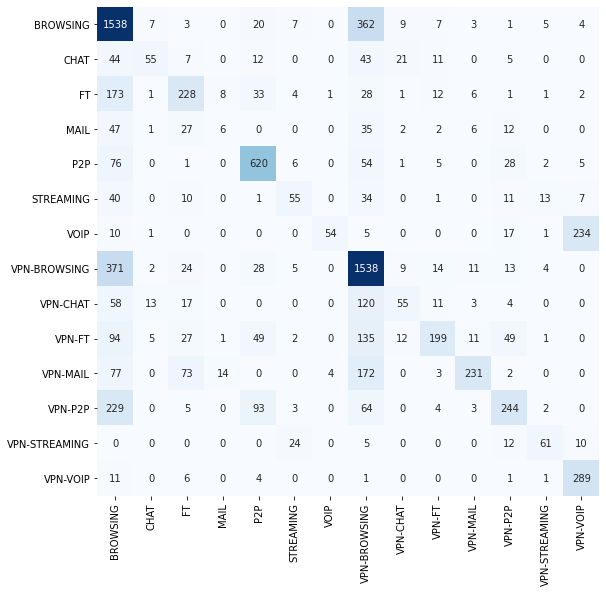

In [118]:
p_train = model.predict(x_train)
p_train_probs = tf.nn.softmax(p_train).numpy()
p_train_class = np.argmax(p_train_probs, axis=1)

print(accuracy_score(p_train_class, y_train_class))
_ = sns.heatmap(tf.math.confusion_matrix(y_train_class, p_train_class), xticklabels=class_names, yticklabels=class_names, cbar=False, cmap='Blues', annot=True, fmt="d")

In [119]:
model.save('/content/drive/MyDrive/NetworkTrafficNet/models/neural_net_32_48_32.h5')

In [120]:
from sklearn import svm
clf = svm.SVC(C=65536.0)
clf.fit(x_train, y_train_class)

SVC(C=65536.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

0.6182745825602969


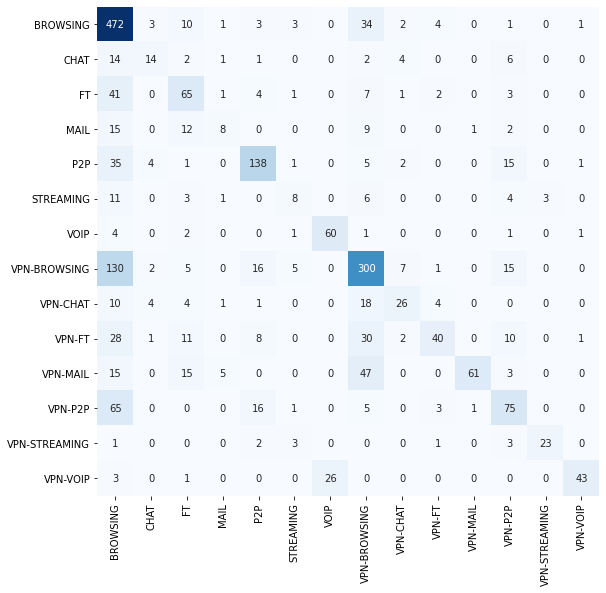

In [121]:
svc_p_test = clf.predict(x_test)
print(accuracy_score(svc_p_test, y_test_class))
_ = sns.heatmap(tf.math.confusion_matrix(y_test_class, svc_p_test), xticklabels=class_names, yticklabels=class_names, cbar=False, cmap='Blues', annot=True, fmt="d")

0.7032228147461164


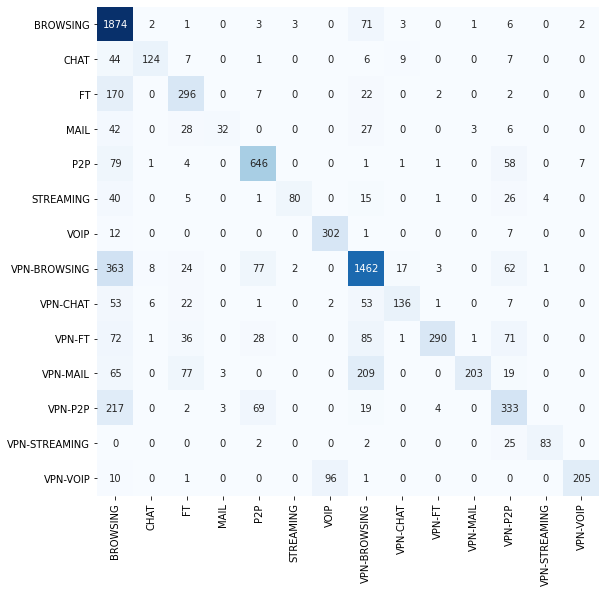

In [122]:
svc_p_train = clf.predict(x_train)
print(accuracy_score(svc_p_train, y_train_class))
_ = sns.heatmap(tf.math.confusion_matrix(y_train_class, svc_p_train), xticklabels=class_names, yticklabels=class_names, cbar=False, cmap='Blues', annot=True, fmt="d")

0.7421150278293135


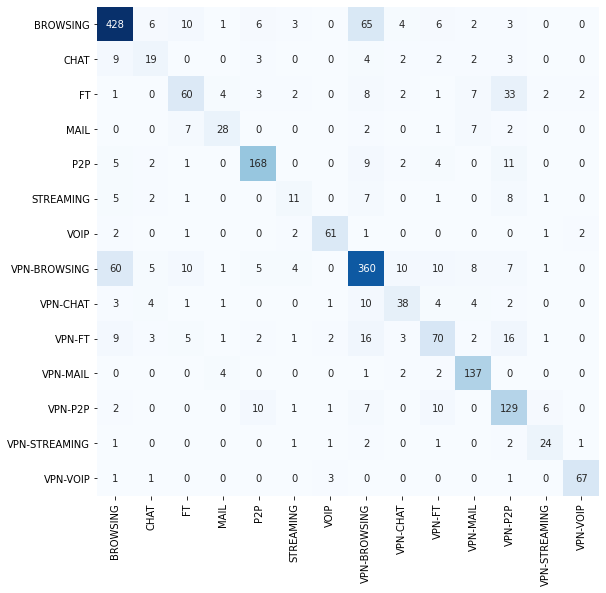

In [128]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(x_train, y_train)
knn_predictions = neigh.predict(x_test)
knn_p_test_probs = tf.identity(knn_predictions).numpy()
knn_p_test_class = np.argmax(knn_p_test_probs, axis=1)

print(accuracy_score(knn_p_test_class, y_test_class))
_ = sns.heatmap(tf.math.confusion_matrix(y_test_class, knn_p_test_class), xticklabels=class_names, yticklabels=class_names, cbar=False, cmap='Blues', annot=True, fmt="d")

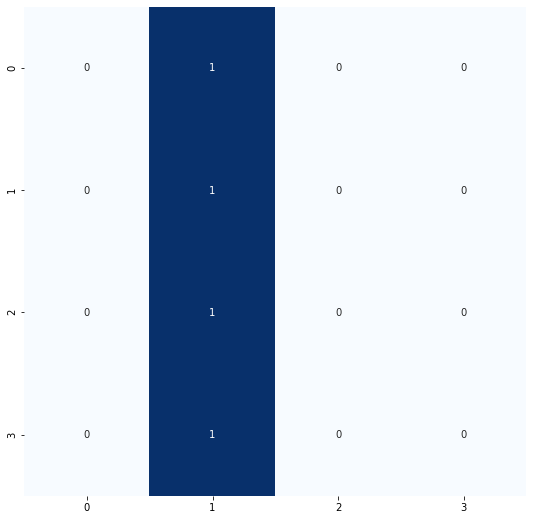

In [136]:
# Just to remind us that the vertical axis is the classification according to the first parameter, and the horizontal is the classification according to the second
_ = sns.heatmap(tf.math.confusion_matrix([0,1,2,3],[1,1,1,1]), cbar=False, cmap='Blues', annot=True, fmt="d")